In [3]:
import os
import sys
import random
import warnings

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from tqdm import tqdm
from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K
from keras.backend.tensorflow_backend import set_session
from keras.optimizers import Adam
import tensorflow as tf

# Set some parameters
IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 3


warnings.filterwarnings('ignore', category=UserWarning, module='skimage')
seed = 42
random.seed = seed
np.random.seed = seed

In [2]:
os.environ['CUDA_DEVICE_ORDER'] = 'PCI_BUS_ID'
os.environ['CUDA_VISIBLE_DEVICES'] = '1'
os.environ['TF_CPP_MIN_LOG_LEVEL']='1'

config = tf.ConfigProto()
config.gpu_options.allow_growth = True
set_session(tf.Session(config=config))

In [21]:
# Get train and test IDs
TRAIN_PATH = '../../data/__download__/stage1_train/'
TEST_PATH = '../../data/__download__/stage2_test_final/'
train_ids = next(os.walk(TRAIN_PATH))[1]
with open('unpredicted_id', 'r') as f:
    test_ids = [line.strip() for line in f.readlines()]
# test_ids = next(os.walk(TEST_PATH))[1]
len(train_ids), len(test_ids)

(670, 312)

# Get the data
Let's first import all the images and associated masks. I downsample both the training and test images to keep things light and manageable, but we need to keep a record of the original sizes of the test images to upsample our predicted masks and create correct run-length encodings later on. There are definitely better ways to handle this, but it works fine for now!

In [13]:
# Get and resize train images and masks
X_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
print('Getting and resizing train images and masks ... ')
sys.stdout.flush()
for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):
    path = TRAIN_PATH + id_
    img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_train[n] = img
    mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
    for mask_file in next(os.walk(path + '/masks/'))[2]:
        mask_ = imread(path + '/masks/' + mask_file)
        mask_ = np.expand_dims(resize(mask_, (IMG_HEIGHT, IMG_WIDTH), mode='constant', 
                                      preserve_range=True), axis=-1)
        mask = np.maximum(mask, mask_)
    Y_train[n] = mask



Getting and resizing train images and masks ... 


100%|██████████| 670/670 [01:20<00:00,  8.35it/s]


In [64]:
# Get and resize test images
X_test = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
sizes_test = []
print('Getting and resizing test images ... ')
sys.stdout.flush()
for n, id_ in tqdm(enumerate(test_ids), total=len(test_ids)):
    path = TEST_PATH + id_

    img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]            
    sizes_test.append([img.shape[0], img.shape[1]])
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_test[n] = img

print('Done!')

Getting and resizing test images ... 


100%|██████████| 312/312 [00:19<00:00, 16.08it/s]

Done!


In [24]:
sizes_test = {}
for n, id_ in tqdm(enumerate(test_ids), total=len(test_ids)):
    path = TEST_PATH + id_
    img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
#     sizes_test.append([img.shape[0], img.shape[1]])
    sizes_test[id_] = [img.shape[0], img.shape[1]]
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_test[n] = img

100%|██████████| 312/312 [00:08<00:00, 38.47it/s]


In [26]:
import pickle
with open('test_sizes_312.pickle' ,'wb') as f:
    pickle.dump(sizes_test,f)

/home/steeve/miniconda3/envs/py36/lib/python3.6/site-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and


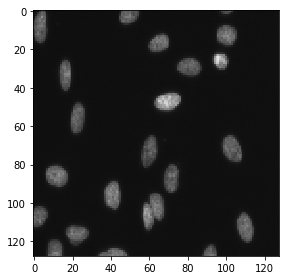

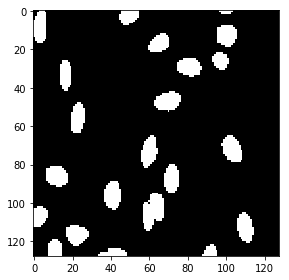

In [27]:
# Check if training data looks all right
ix = random.randint(0, len(train_ids))
imshow(X_train[ix])
plt.show()
imshow(np.squeeze(Y_train[ix]))
plt.show()

In [28]:
# Define IoU metric
def mean_iou(y_true, y_pred):
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        y_pred_ = tf.to_int32(y_pred > t)
        score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2, y_true)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([up_opt]):
            score = tf.identity(score)
        prec.append(score)
    return K.mean(K.stack(prec), axis=0)


In [42]:
# Build U-Net model
def get_model(base_filters=32):
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    s = Lambda(lambda x: x / 255) (inputs)

    c1 = Conv2D(base_filters, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (s)
    c1 = Dropout(0.1) (c1)
    c1 = Conv2D(base_filters, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c1)
    p1 = MaxPooling2D((2, 2)) (c1)

    c2 = Conv2D(base_filters*2, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p1)
    c2 = Dropout(0.1) (c2)
    c2 = Conv2D(base_filters*2, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c2)
    p2 = MaxPooling2D((2, 2)) (c2)

    c3 = Conv2D(base_filters*4, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p2)
    c3 = Dropout(0.2) (c3)
    c3 = Conv2D(base_filters*4, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c3)
    p3 = MaxPooling2D((2, 2)) (c3)

    c4 = Conv2D(base_filters*8, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p3)
    c4 = Dropout(0.2) (c4)
    c4 = Conv2D(base_filters*8, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c4)
    p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

    c5 = Conv2D(base_filters*16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p4)
    c5 = Dropout(0.3) (c5)
    c5 = Conv2D(base_filters*16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c5)

    u6 = Conv2DTranspose(base_filters*8, (2, 2), strides=(2, 2), padding='same') (c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(base_filters*8, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u6)
    c6 = Dropout(0.2) (c6)
    c6 = Conv2D(base_filters*8, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c6)

    u7 = Conv2DTranspose(base_filters*4, (2, 2), strides=(2, 2), padding='same') (c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(base_filters*4, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u7)
    c7 = Dropout(0.2) (c7)
    c7 = Conv2D(base_filters*4, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c7)

    u8 = Conv2DTranspose(base_filters*2, (2, 2), strides=(2, 2), padding='same') (c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(base_filters*2, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u8)
    c8 = Dropout(0.1) (c8)
    c8 = Conv2D(base_filters*2, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c8)

    u9 = Conv2DTranspose(base_filters*4, (2, 2), strides=(2, 2), padding='same') (c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(base_filters*4, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u9)
    c9 = Dropout(0.1) (c9)
    c9 = Conv2D(base_filters*4, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c9)

    outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

    model = Model(inputs=[inputs], outputs=[outputs])
    model.compile(optimizer=Adam(amsgrad=True), loss='binary_crossentropy', metrics=[mean_iou])
    return model

In [19]:
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold
def train_bagging(X, y, model_func, fold_count, batch_size, num_epoch, patience, verbose=0):
    global seed
    best_iou_score = -np.inf
    best_weights = None
    val_predict= np.zeros(y.shape)
    kf = KFold(n_splits=fold_count, random_state=seed, shuffle=True)
#     skf = StratifiedKFold(n_splits=fold_count, random_state=None, shuffle=False)
    fold_id = -1
    model_list = []
    for train_index, test_index in kf.split(X):

        fold_id +=1 
        print("starting fold {}".format(fold_id))
        model = model_func()
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]


        earlystopper = EarlyStopping(patience=patience, monitor='val_mean_iou', mode='max')
        checkpoint_path =  'weights/'+fname+'.h5'
        checkpointer = ModelCheckpoint(checkpoint_path,monitor='val_mean_iou',mode='max', save_best_only=True, verbose=1)
        callbacks = [earlystopper, checkpointer]
        model.fit(X_train,y_train, batch_size=batch_size, verbose=1, callbacks=callbacks, validation_data=(X_test, y_test), epochs=num_epoch)
        model.load_weights(checkpoint_path)
        y_pred = model.predict(X_test)
        
        val_predict[test_index] = y_pred
        model_list.append(model)            
            
#     model.set_weights(best_weights)
    return model_list, val_predict

In [33]:
fname = 'unet_f64'

In [45]:
# get_model_func = lambda : get_model(16)
model = get_model()
batch_size= 4
epochs = 80
num_epoch= 60 
patience=6
earlystopper = EarlyStopping(patience=patience, monitor='val_loss', mode='min')
checkpoint_path =  '../../results/unet-weights/'+fname+'.h5'
checkpointer = ModelCheckpoint(checkpoint_path,monitor='val_loss',mode='min', save_best_only=True, verbose=1)
callbacks = [earlystopper, checkpointer]
model.fit(X_train,Y_train, batch_size=batch_size, verbose=1, callbacks=callbacks, validation_split=0.1, epochs=num_epoch)
# model_list, val_predict = train_bagging(X_train, Y_train, get_model_func, fold_count= 5, batch_size=batch_size, num_epoch= epochs, patience=patience)

Train on 603 samples, validate on 67 samples
Epoch 1/60
603/603 [==============================] - 22s 37ms/step - loss: 0.4322 - mean_iou: 0.0401 - val_loss: 0.1908 - val_mean_iou: 0.0726

Epoch 00001: val_loss improved from inf to 0.19079, saving model to ../../results/unet-weights/unet_f64.h5
Epoch 2/60
603/603 [==============================] - 11s 19ms/step - loss: 0.1636 - mean_iou: 0.1362 - val_loss: 0.1247 - val_mean_iou: 0.1822

Epoch 00002: val_loss improved from 0.19079 to 0.12475, saving model to ../../results/unet-weights/unet_f64.h5
Epoch 3/60
603/603 [==============================] - 12s 20ms/step - loss: 0.1200 - mean_iou: 0.2156 - val_loss: 0.1048 - val_mean_iou: 0.2360

Epoch 00003: val_loss improved from 0.12475 to 0.10476, saving model to ../../results/unet-weights/unet_f64.h5
Epoch 4/60
603/603 [==============================] - 12s 20ms/step - loss: 0.1064 - mean_iou: 0.2533 - val_loss: 0.0912 - val_mean_iou: 0.2673

Epoch 00004: val_loss improved from 0.10476 to

In [65]:
# for index, model in enumerate(model_list):
#     if index == 0: 
#         y_pred = model.predict(X_test, batch_size=batch_size)
#     else:
#         y_pred += model.predict(X_test, batch_size=batch_size)
    
# preds_test = y_pred / len(model_list)
preds_test = model.predict(X_test)

In [66]:
preds_test = (preds_test > 0.5).astype(np.uint8)

In [56]:
# Run-length encoding stolen from https://www.kaggle.com/rakhlin/fast-run-length-encoding-python
def rle_encoding(x):
    dots = np.where(x.T.flatten() == 1)[0]
    run_lengths = []
    prev = -2
    for b in dots:
        if (b>prev+1): run_lengths.extend((b + 1, 0))
        run_lengths[-1] += 1
        prev = b
    return run_lengths

def prob_to_rles(x, cutoff=0.5):
    lab_img = label(x > cutoff)
    for i in range(1, lab_img.max() + 1):
        yield rle_encoding(lab_img == i)

In [67]:
preds_test_upsampled = []
for i in range(len(preds_test)):
    preds_test_upsampled.append(resize(np.squeeze(preds_test[i]), 
                                       (sizes_test[i][0], sizes_test[i][1]), 
                                       mode='constant', preserve_range=True))

In [68]:
new_test_ids = []
rles = []
for n, id_ in enumerate(test_ids):
    rle = list(prob_to_rles(preds_test_upsampled[n]))
    rles.extend(rle)
    new_test_ids.extend([id_] * len(rle))

In [70]:
sub = pd.DataFrame()
sub['ImageId'] = new_test_ids
sub['EncodedPixels'] = pd.Series(rles).apply(lambda x: ' '.join(str(y) for y in x))
sub.to_csv('../../results/unet-weights/'+fname+'.csv', index=False)

In [69]:
fname

'unet_f64'

In [3]:
with open('unpredicted_id' ,'r') as f:
    unpredicted_id_dir = ['stage2_test_final/'+line.strip() for line in f.readlines()] 
unpredicted_id_dir

['stage2_test_final/0401b552f739d51b556e9f2f85cdd52191f957d8b453ea3d2e61b32ef1624490',
 'stage2_test_final/04022ee855ec1e9b93532bf00e709e10305e3084ca9b452368f9c1547d76cb7e',
 'stage2_test_final/04387d228734fd5993d61199704cbd741762b10e31856eabe92552c8790ca7e0',
 'stage2_test_final/0517932ff0b7bc51c6ed946afc6437f82f2b1420e592b09b67874e129635437a',
 'stage2_test_final/0588ea30da5deecd3f4748fbfa525c188c74ca573432c5ca63ff0b6ac81fcdcb',
 'stage2_test_final/0801c13e30c0e1c6918699ba8b28fb5381513de55902de7c9df2455a35482a66',
 'stage2_test_final/081302bcd859ca4ace25ef02f4ed278f00ffb11b105dabefdc412abba25bbfab',
 'stage2_test_final/087fe46ef42f17482a798f31de7e679e1c66ce306bd3f3ac779c989b0a6b76df',
 'stage2_test_final/09338db90dccc899f56ba39d7ff660243545db9a7efd28b2f5d308215d8e8060',
 'stage2_test_final/097224ce9b9295744e76c55616d3122fc1790bd40e31f247d7825e9ef90e98a3',
 'stage2_test_final/09ecdeff9ce879e5c4ab1ed0cf7fa8f41dd8ea0352148effeb6171240f4140ee',
 'stage2_test_final/0fd3ed3fcef2451fa5b087b

In [4]:
with open('unpredicted_id_dir' ,'w') as f:
    for d in unpredicted_id_dir:
        f.write(f'{d}\n')
# unpredicted_id_dir